In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.datasets as datasets
# from torchvision.datasets import MNIST
from keras.datasets import mnist
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision
import torchsummary

from networks.generator import ResNetGenerator, Decoder, Encoder, ResNetUnetGenerator

Using TensorFlow backend.
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
simple = transforms.Compose([
    transforms.ToTensor(),
])
mnist_trainset = datasets.MNIST(root='./datasets/mnist', train=True, download=True, transform=simple)

In [3]:
model1 = ResNetUnetGenerator(c_dim=1, conv_dim=32, repeat_num=0, n_down=2)
encoder = Encoder()
torchsummary.summary(model1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,568
    InstanceNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 14, 14]          18,432
    InstanceNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
 DownsamplingBlock-7           [-1, 64, 14, 14]               0
            Conv2d-8            [-1, 128, 7, 7]          73,728
    InstanceNorm2d-9            [-1, 128, 7, 7]             256
             ReLU-10            [-1, 128, 7, 7]               0
DownsamplingBlock-11            [-1, 128, 7, 7]               0
       Bottleneck-12            [-1, 128, 7, 7]               0
  ConvTranspose2d-13           [-1, 64, 14, 14]          73,728
  ConvTranspose2d-14           [-1, 64,

In [4]:
model1.decoder.skip

ModuleList(
  (0): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
)

In [5]:
class NetworkBase(nn.Module):
    def __init__(self):
        super(NetworkBase, self).__init__()
        self._name = 'BaseNetwork'

    @property
    def name(self):
        return self._name

    def init_weights(self):
        self.apply(self._weights_init_fn)

    def _weights_init_fn(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0)
        elif classname.find('BatchNorm2d') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def _get_norm_layer(self, norm_type='batch'):
        if norm_type == 'batch':
            norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        elif norm_type == 'instance':
            norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
        elif norm_type == 'batchnorm2d':
            norm_layer = nn.BatchNorm2d
        else:
            raise NotImplementedError('normalization layer [%s] is not found' % norm_type)

        return norm_layer

    def forward(self, *input):
        raise NotImplementedError

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class ResidualBlock(nn.Module):
    """Residual Block."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True))

    def forward(self, x):
        return x + self.main(x)


class ResNetGenerator1(nn.Module):
    """Generator. Encoder-Decoder Architecture."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=9, k_size=4, n_down=2):
        super(ResNetGenerator1, self).__init__()
        self._name = 'resnet_generator'

        layers = []
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-Sampling
        curr_dim = conv_dim
        for i in range(n_down):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=k_size, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-Sampling
        for i in range(n_down):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=k_size, stride=2, padding=1,
                                             output_padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())

        self.model = nn.Sequential(*layers)

    def forward(self, x, c=None):
        if c is not None:
            # replicate spatially and concatenate domain information
            c = c.unsqueeze(2).unsqueeze(3)
            c = c.expand(c.size(0), c.size(1), x.size(2), x.size(3))
            x = torch.cat([x, c], dim=1)
        return self.model(x)

In [103]:
class Encoderdecoder(nn.Module):
    """Generator. Encoder-Decoder Architecture."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=9, k_size=4, n_down=2):
        super(Encoderdecoder, self).__init__()
        self._name = 'resnet_generator'

        layers = []
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
        c_dim = conv_dim
        conv_dim *= 2
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
        c_dim = conv_dim
        conv_dim *= 2
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
        c_dim = conv_dim
        conv_dim *= 2
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
        c_dim = conv_dim
        conv_dim *= 2
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
        c_dim = conv_dim
        conv_dim *= 2
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=3, stride=1, padding=0, bias=False))
#         c_dim = conv_dim
#         conv_dim *= 2
        layers.append(nn.ConvTranspose2d(conv_dim, conv_dim//2, kernel_size=k_size, stride=1, padding=0,
                                             output_padding=0, bias=False))
#         c_dim = conv_dim
        conv_dim = conv_dim // 2
        layers.append(nn.ConvTranspose2d(conv_dim, conv_dim//2, kernel_size=k_size, stride=1, padding=0,
                                             output_padding=0, bias=False))
#         c_dim = conv_dim
        conv_dim = conv_dim // 2
        layers.append(nn.ConvTranspose2d(conv_dim, conv_dim//2, kernel_size=k_size, stride=1, padding=0,
                                             output_padding=0, bias=False))
        conv_dim = conv_dim // 2
        layers.append(nn.ConvTranspose2d(conv_dim, 1, kernel_size=k_size, stride=1, padding=0,
                                             output_padding=0, bias=False))

        self.model = nn.Sequential(*layers)

    def forward(self, x, c=None):
        if c is not None:
            # replicate spatially and concatenate domain information
            c = c.unsqueeze(2).unsqueeze(3)
            c = c.expand(c.size(0), c.size(1), x.size(2), x.size(3))
            x = torch.cat([x, c], dim=1)
        return self.model(x)

In [104]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [105]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [106]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))  # adapt this if using `channels_first` i

In [107]:
x_train[0].shape

(1, 28, 28)

In [108]:
def salt_and_pepper(x_train,x_test,factor):
    noise_factor = factor
    
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [109]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [110]:
def gamma_noise(x_train,x_test,shape,scale=1.0):
    
    row,col,ch = x_train[0].shape
    
    x_train_noisy = x_train + np.random.gamma(shape,scale,x_train.shape)
    x_test_noisy = x_test + np.random.gamma(shape,scale,x_test.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [111]:
x_train_noisy, x_test_noisy = gamma_noise(x_train,x_test,0.5)
class Mnistdenoizing_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, x_train_noisy):
        self.x_train_noisy = x_train_noisy
        self.x_train = x_train
        
    def __getitem__(self, idx):
        return (torch.tensor(self.x_train[idx], requires_grad=True).type(torch.float), 
        torch.tensor(self.x_train_noisy[idx], requires_grad=True).type(torch.float))
    
    def __len__(self):
        return len(self.x_train)

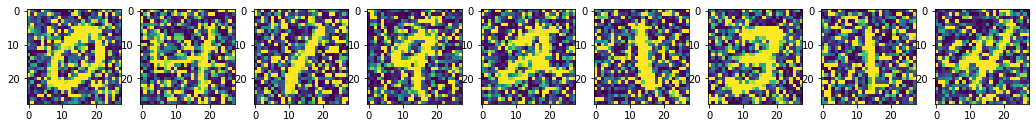

In [112]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
plt.show()

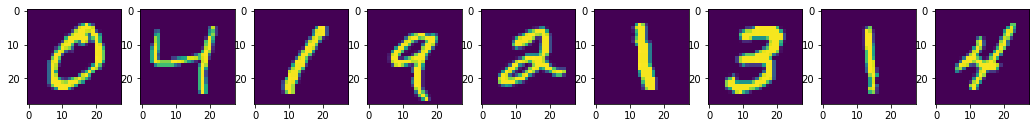

In [113]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
plt.show()

In [114]:
for param in model1.parameters():
#     param.data = param.data.float()
    print(torch.typename(param.data))

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor


In [115]:
device = torch.device('cpu')
model1 = model1.float()

In [116]:
BATCH_SIZE = 1
criterian = nn.MSELoss()
d = Mnistdenoizing_dataset(x_train, x_train_noisy)
def init_weight(layer):
    if type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
        torch.nn.init.uniform_(layer.weight)
# model1.apply(init_weight)
def train(model, num_epoch=10, gd=None):
    if gd is None:
        gd = optim.Adam(model.parameters())
    dataloader = DataLoader(d, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in tqdm(range(num_epoch)):
        model.train(True)
        for i, batch in enumerate(dataloader):
            gd.zero_grad()
            f = model(batch[1])
            loss = criterian(batch[0], f)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
#         for i, (batch) in enumerate(dataloader_test):
#             batch = batch.to(device=device)
#             scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
#         test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}")

In [117]:
# (list(model1.parameters()) + list(map(lambda x: x.parameters(), model1.decoder.skip)))
# model1 = model1.float()
# torch.set_default_tensor_type('torch.FloatTensor')
train(model1)
# model1.parameters




  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [74]:
dataloader = DataLoader(d, batch_size=BATCH_SIZE, shuffle=True)
a, b  = next(iter(dataloader))

In [75]:
# plt.imshow(b[0][0])
# a.requires_grad
# a.shape
# model1(a).shape
# a = torch.tensor(np., dtype=torch.float)
# a = a.double()
# model1.decoder.skip[0](a)
a.shape

torch.Size([1, 1, 28, 28])

In [76]:
with torch.no_grad():
    res = model1.forward(torch.tensor(x_test_noisy[8]).float().unsqueeze(0))

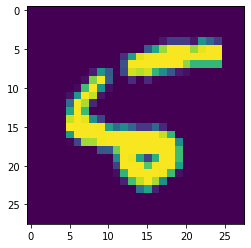

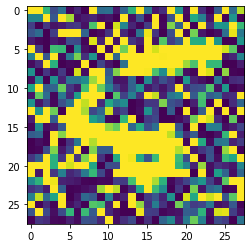

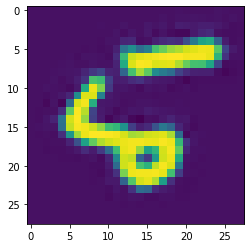

In [77]:
plt.imshow(x_test[8][0])
plt.show()
plt.imshow(x_test_noisy[8][0])
plt.show()
plt.imshow(res.detach().numpy()[0][0])
plt.show()